## Petrophysical properties inversion from elastic properties

In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
from random import randint
from wiggle.wiggle import wiggle
from matplotlib.pyplot import figure
import math
import tensorflow as tf

In [2]:
# Checking the devices available for use in AWS
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9147765702128540810
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7629547064973587029
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15422911402138330234
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11326753997
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8265751170691270084
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [3]:
# Loading the Vp, Vs and Density data

dataframe = sio.loadmat('../../../Data_generation_base_case/Train_DataSyn1_time_clip.mat')
Vp = dataframe['VpMat']
Vp = np.reshape(Vp, (Vp.shape[0]*Vp.shape[1], Vp.shape[2]))
Vs = dataframe['VsMat']
Vs = np.reshape(Vs, (Vs.shape[0]*Vs.shape[1], Vs.shape[2]))
RHOB = dataframe['RHOBMat']
RHOB = np.reshape(RHOB, (RHOB.shape[0]*RHOB.shape[1], RHOB.shape[2]))

depth = dataframe['depthVec']

# Loading facies, porosity, vclay and water saturation data 
dataframe_facies = sio.loadmat('../../../Data_generation_base_case/Train_FaciesMat.mat')
facies = dataframe_facies['zFaciesMat']
facies = np.reshape(facies, (facies.shape[0]*facies.shape[1], facies.shape[2]))

dataframe_porosity = sio.loadmat('../../../Data_generation_base_case/Train_PhiMat.mat')
porosity = dataframe_porosity['zPhiMat']
porosity = np.reshape(porosity, (porosity.shape[0]*porosity.shape[1], porosity.shape[2]))

dataframe_vclay = sio.loadmat('../../../Data_generation_base_case/Train_ClayMat.mat')
vclay = dataframe_vclay['zClayMat']
vclay = np.reshape(vclay, (vclay.shape[0]*vclay.shape[1], vclay.shape[2]))

dataframe_Sw = sio.loadmat('../../../Data_generation_base_case/Train_SwMat.mat')
Sw = dataframe_Sw['zSwMat']
Sw = np.reshape(Sw, (Sw.shape[0]*Sw.shape[1], Sw.shape[2]))


Text(0.5,0,'Ip')

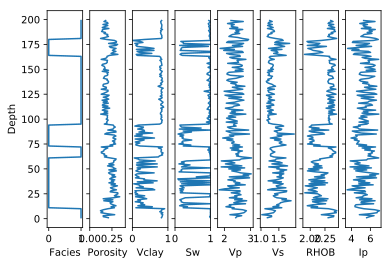

In [4]:
# Plot of loaded data

sample_number = 12
f, axarr = plt.subplots(1, 8, sharey = True)

axarr[0].plot(facies[sample_number, :], depth)
axarr[0].set_xlabel("Facies")
axarr[0].set_ylabel("Depth")

axarr[1].plot(porosity[sample_number, :], depth)
axarr[1].set_xlabel("Porosity")
axarr[1].set_xlim(0,0.4)

axarr[2].plot(vclay[sample_number, :], depth)
axarr[2].set_xlabel("Vclay")
axarr[2].set_xlim(0,1)

axarr[3].plot(Sw[sample_number, :], depth)
axarr[3].set_xlabel("Sw")
axarr[3].set_xlim(0,1)

axarr[4].plot(Vp[sample_number, :], depth)
axarr[4].set_xlabel("Vp")
# plt.xlim(0,1)

axarr[5].plot(Vs[sample_number, :], depth)
axarr[5].set_xlabel("Vs")
# plt.xlim(0,1)

axarr[6].plot(RHOB[sample_number, :], depth)
axarr[6].set_xlabel("RHOB")
# plt.xlim(0,1)

axarr[7].plot(Vp[sample_number, :]*RHOB[sample_number, :], depth)
axarr[7].set_xlabel("Ip")

In [5]:
# AVO and source parameters 
src_len=np.int(60)
freq=40
dt=7e-4
# ntheta=46
thetaStart=0
thetaEnd=30
thetaInc=5
theta=np.arange(thetaStart,thetaEnd+thetaInc,thetaInc)
ntheta=theta.size
# nt=201
# ncdp=1111
angle=np.reshape(theta,[1,ntheta])
# theta=np.arange(0,ntheta,1)
print('angle:', angle.shape)
print('angle:', angle)

angle: (1, 7)
angle: [[ 0  5 10 15 20 25 30]]


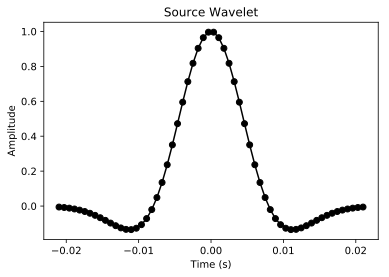

In [6]:
# Generate the seismic wavelet
def ricker(f,n,dt,t0):

    T = dt*(np.floor(n/2));
    t = np.linspace(-T,T,n)
    tau = t-t0;
    pi=np.pi
    s = (1-tau*tau*f**2*pi**2)*np.exp(-tau**2*pi**2*f**2);
    rw = s;

    return rw,t
src,tsrc=ricker(freq,src_len,dt,0)
plt.plot(tsrc,src, '-ok')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Source Wavelet")
plt.show()

In [7]:
# Convert Vp, Vs and Density logs from depth to time 
time = np.zeros((Vp.shape[0], Vp.shape[1]+1))

for i in range(time.shape[0]):
    depth_diff = np.mean(np.diff(depth.T))
    time[i,0] = 0
    time[i,1:] = 2*np.cumsum(depth_diff/(Vp[i,:]*1e3))

time = time[:,0:-1]
# Interpolate the time values such that all logs have the same dt_log
end_time = (np.max(time))
time_upscaled = np.arange(0, end_time, dt)

Vp_time = np.zeros((Vp.shape[0], time_upscaled.shape[0]))
Vs_time = np.zeros((Vs.shape[0], time_upscaled.shape[0]))
RHOB_time = np.zeros((RHOB.shape[0], time_upscaled.shape[0]))
for i in range(time.shape[0]):
    Vp_time[i,:] = np.interp(time_upscaled, time[i,:], Vp[i,:])
    Vs_time[i,:] = np.interp(time_upscaled, time[i,:], Vs[i,:])
    RHOB_time[i,:] = np.interp(time_upscaled, time[i,:], RHOB[i,:])
    
nt = time_upscaled.shape[0]    

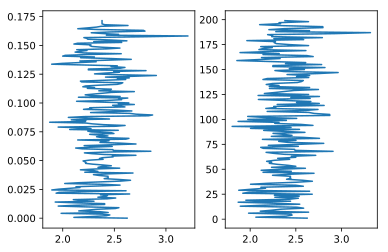

In [8]:
sample_number = 10
plt.subplot(1,2,1)
plt.plot(Vp_time[sample_number,:], time_upscaled)
plt.subplot(1,2,2)
plt.plot(Vp[sample_number,:], depth)


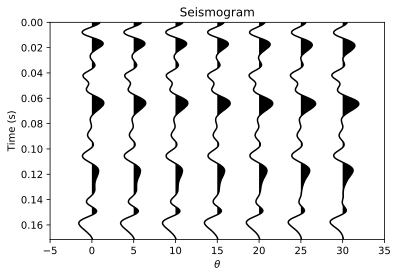

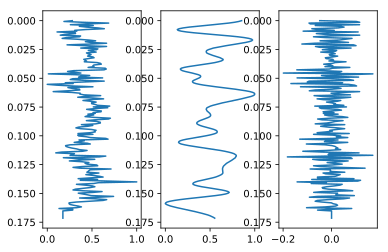

In [10]:
# Load forward modeled seismic data and Rpp
seis = np.load('../../../Data_generation_base_case/seismic_forward_modeled.npy')
Rpp = np.load('../../../Data_generation_base_case/Rpp_forward_modeled.npy')

sample_number = 20
wiggle(np.squeeze(seis[sample_number,:,:]),time_upscaled,theta)
plt.title("Seismogram")
plt.xlabel("$\\theta$")
plt.ylabel("Time (s)")
plt.show()

impedance_time = Vp_time * RHOB_time
impedance_time_sample = impedance_time[sample_number,:]
plt.subplot(1,3,1)
plt.plot((impedance_time_sample - np.min(impedance_time_sample))/(np.max(impedance_time_sample)-np.min(impedance_time_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,2)
seis_sample = np.squeeze(seis[sample_number,:,0])
plt.plot((seis_sample - np.min(seis_sample))/(np.max(seis_sample) - np.min(seis_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,3)
plt.plot(np.squeeze(Rpp[sample_number,:,0]), time_upscaled)
plt.gca().invert_yaxis()

In [11]:
# Import keras modules for CNN

from keras import layers, initializers, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling1D, MaxPooling2D, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import LeakyReLU, Reshape
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils, normalize
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils import np_utils
# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')

import sklearn.model_selection
import pydot

Using TensorFlow backend.


In [12]:
# Getting the input data (normalized) and output data 


# Concatenate Vp, Vs and Density 
num_examples = Vp_time.shape[0]
emodel = np.concatenate((Vp_time,Vs_time,RHOB_time), axis=1)
emodel = emodel.reshape((num_examples, 3, nt))


# Concatenate Porosity, Vclay, Sw 
num_examples = porosity.shape[0]
ndepth = porosity.shape[1]
petromodel = np.concatenate((porosity,vclay,Sw), axis=1)
petromodel = petromodel.reshape((num_examples, 3, ndepth))

# Split data into train and test set - elastic model
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(emodel, 
                                                                            petromodel, test_size=0.2, random_state=1)
# # Normalizing output
# Y_train = normalize(Y_train, axis=2, order=2)
# Y_test = normalize(Y_test, axis=2, order=2)


# Add 4th dimension of number of channels=1 to the input data
X_train = np.expand_dims(X_train, axis=3)
# # X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)


print ("number of training examples = " + str(X_train.shape[0]))
# print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))


number of training examples = 2000
number of test examples = 500
X_train shape: (2000, 3, 246, 1)
Y_train shape: (2000, 3, 199)
X_test shape: (500, 3, 246, 1)
Y_test shape: (500, 3, 199)


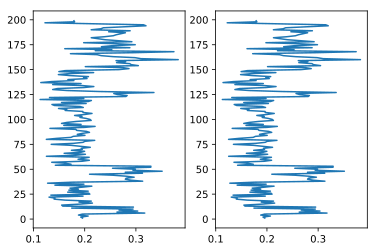

In [13]:
sample_number = 10

plt.subplot(1,2,1)
plt.plot(Y_train[sample_number, 0, :], depth)

plt.subplot(1,2,2)
plt.plot(Y_train[sample_number, 0, :], depth)

In [14]:
# Building neural network for elastic properties prediction in Keras 
given_seed = 3 # For repeatibility

def elastic_petronet(input_shape):
    """
    Implementation of the AVONet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input_shape. Input = input angle gather 
    X_input = Input(input_shape)

    X = X_input

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(60, (1, 10), strides=(1, 1), name='conv0',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool0')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(1, (1, 10), strides=(1, 1), name='conv1',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn1')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool1')(X)
      

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
#     X = Dense(1200, name='fc1')(X)
#     X = Activation('relu')(X)
    X = Dense(199*3, name='fc1')(X)
    X = Activation('sigmoid')(X)
    
    X = Reshape((3, 199))(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='ElasticPetroModel')

    return model
    ### END CODE HERE ###

In [15]:
# Create the model
ElasticPetroModel = elastic_petronet(X_train.shape[1:])


Instructions for updating:
Colocations handled automatically by placer.


In [16]:
# Summary and plot of the model

ElasticPetroModel.summary()


# plot_model(AVOModel)
# SVG(model_to_dot(ElasticModel).create(prog='dot', format='svg'))
# plot_model(ElasticModel, to_file='./Figures/model_plot.png', show_shapes=True, show_layer_names=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 246, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 3, 237, 60)        660       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 3, 237, 60)        240       
_________________________________________________________________
activation_1 (Activation)    (None, 3, 237, 60)        0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 2, 236, 60)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 227, 1)         601       
_________________________________________________________________
bn1 (BatchNormalization)     (None, 2, 227, 1)         4         
__________

In [17]:
# Learning rate scheduler
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 50.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [18]:
# Compile the model with optimization algorithm, loss function
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

ElasticPetroModel.compile(loss='mean_squared_error', optimizer = adam)

In [19]:
# Start the training
# Using learning rate scheduler
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
history = ElasticPetroModel.fit(X_train, Y_train, validation_split=0.2, epochs=250, batch_size=32, callbacks=callbacks_list)

# history = ElasticPetroModel.fit(X_train, Y_train, validation_split=0.2, epochs=250, batch_size=32)

Instructions for updating:
Use tf.cast instead.
Train on 1600 samples, validate on 400 samples
Epoch 1/250
1600/1600 [==============================] - 2s 1ms/step - loss: 0.0837 - val_loss: 0.0979
Epoch 2/250
1600/1600 [==============================] - 0s 263us/step - loss: 0.0689 - val_loss: 0.1197
Epoch 3/250
1600/1600 [==============================] - 0s 253us/step - loss: 0.0565 - val_loss: 0.1172
Epoch 4/250
1600/1600 [==============================] - 0s 254us/step - loss: 0.0500 - val_loss: 0.1147
Epoch 5/250
1600/1600 [==============================] - 0s 253us/step - loss: 0.0436 - val_loss: 0.0772
Epoch 6/250
1600/1600 [==============================] - 0s 249us/step - loss: 0.0412 - val_loss: 0.0457
Epoch 7/250
1600/1600 [==============================] - 0s 250us/step - loss: 0.0386 - val_loss: 0.0420
Epoch 8/250
1600/1600 [==============================] - 0s 247us/step - loss: 0.0371 - val_loss: 0.0435
Epoch 9/250
1600/1600 [==============================] - 0s 253us/s

Epoch 152/250
1600/1600 [==============================] - 0s 245us/step - loss: 0.0269 - val_loss: 0.0330
Epoch 153/250
1600/1600 [==============================] - 0s 242us/step - loss: 0.0269 - val_loss: 0.0330
Epoch 154/250
1600/1600 [==============================] - 0s 242us/step - loss: 0.0269 - val_loss: 0.0330
Epoch 155/250
1600/1600 [==============================] - 0s 243us/step - loss: 0.0269 - val_loss: 0.0330
Epoch 156/250
1600/1600 [==============================] - 0s 243us/step - loss: 0.0269 - val_loss: 0.0330
Epoch 157/250
1600/1600 [==============================] - 0s 242us/step - loss: 0.0269 - val_loss: 0.0330
Epoch 158/250
1600/1600 [==============================] - 0s 241us/step - loss: 0.0269 - val_loss: 0.0330
Epoch 159/250
1600/1600 [==============================] - 0s 242us/step - loss: 0.0269 - val_loss: 0.0330
Epoch 160/250
1600/1600 [==============================] - 0s 241us/step - loss: 0.0269 - val_loss: 0.0330
Epoch 161/250
1600/1600 [============

In [20]:
# Testing and evaluating the model
preds = ElasticPetroModel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds))
# print ("Test Accuracy = " + str(preds[1]))

500/500 [==============================] - 0s 166us/step

Loss = 0.033356886923313143


0.14775758481025697

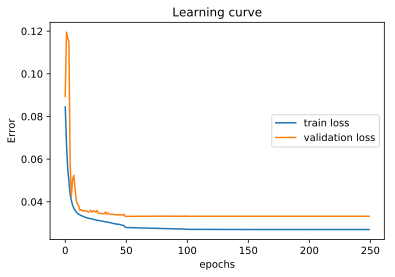

In [19]:
# Plotting the learning curve 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])


plt.title('Learning curve')
# plt.ylabel('Error/Accuracy')
plt.ylabel('Error')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'], loc='center right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

In [34]:
# Save trained model 
# serialize model to JSON
model_json = ElasticPetroModel.to_json()
with open("elastic_petromodel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
ElasticPetroModel.save_weights("ElasticPetroModel.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# Load saved model
# load json and create model
json_file = open('elastic_petromodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
ElasticPetroModel = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("ElasticPetroModel.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

ElasticPetroModel.compile(loss='mean_squared_error', optimizer = adam)


# To evaluate run the "Testing and evaluating the model" cell

In [21]:
# Predict training and test data using the trained network
test_output = ElasticPetroModel.predict(X_test)
train_output = ElasticPetroModel.predict(X_train)

In [22]:
# RMSE with respect to mean 
rmse_train = np.sqrt(np.mean(((train_output - Y_train)**2).mean(axis=2), axis = 0))/np.mean(np.mean(Y_train, axis = 0), axis=1)
rmse_test = np.sqrt(np.mean(((test_output - Y_test)**2).mean(axis=2), axis = 0))/np.mean(np.mean(Y_test, axis = 0), axis=1)

print("Training error = ", rmse_train)
print("Test error = ", rmse_test)

Training error =  [0.20662824 0.27773547 0.31675724]
Test error =  [0.22533039 0.30057793 0.34632563]


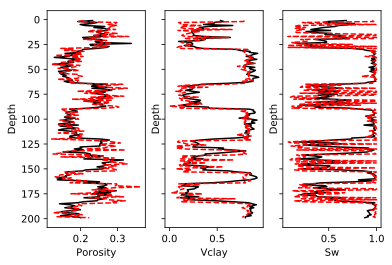

In [21]:
# Checking training data

sample_number = 25
f, axarr = plt.subplots(1, 3, sharey = True)

axarr[0].plot(train_output[sample_number, 0, :], depth, '-k')
axarr[0].plot(Y_train[sample_number, 0, :], depth, '--r')
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(train_output[sample_number, 1, :], depth, '-k')
axarr[1].plot(Y_train[sample_number, 1, :], depth, '--r')
axarr[1].set_xlabel("Vclay")
axarr[1].set_ylabel("Depth")
axarr[1].invert_yaxis()
# axarr[1].set_xlim(1,2)

axarr[2].plot(train_output[sample_number, 2, :], depth, '-k')
axarr[2].plot(Y_train[sample_number, 2, :], depth, '--r')
axarr[2].set_xlabel("Sw")
axarr[2].set_ylabel("Depth")
axarr[2].invert_yaxis()
# axarr[2].set_xlim(1.5,3)

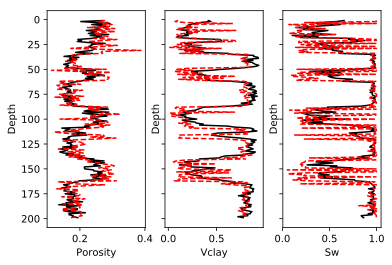

In [22]:
# Checking testing data

sample_number = 12
f, axarr = plt.subplots(1, 3, sharey = True)

axarr[0].plot(test_output[sample_number, 0, :], depth, '-k')
axarr[0].plot(Y_test[sample_number, 0, :], depth, '--r')
axarr[0].set_xlabel("Porosity")
axarr[0].set_ylabel("Depth")
axarr[0].invert_yaxis()
# axarr[0].set_xlim(1.5,3.1)

axarr[1].plot(test_output[sample_number, 1, :], depth, '-k')
axarr[1].plot(Y_test[sample_number, 1, :], depth, '--r')
axarr[1].set_xlabel("Vclay")
axarr[1].set_ylabel("Depth")
axarr[1].invert_yaxis()
# axarr[1].set_xlim(1,2)

axarr[2].plot(test_output[sample_number, 2, :], depth, '-k')
axarr[2].plot(Y_test[sample_number, 2, :], depth, '--r')
axarr[2].set_xlabel("Sw")
axarr[2].set_ylabel("Depth")
axarr[2].invert_yaxis()
# axarr[2].set_xlim(1.5,3)

In [23]:
# Correlation coefficient between true and predicted traces 

Porosity_corr_train = np.zeros(train_output.shape[0])
Vclay_corr_train = np.zeros(train_output.shape[0])
Sw_corr_train = np.zeros(train_output.shape[0])
for i in range(train_output.shape[0]):
    Porosity_corr_train[i] = np.corrcoef(train_output[i,0,:], Y_train[i,0,:])[0,1]
    Vclay_corr_train[i] = np.corrcoef(train_output[i,1,:], Y_train[i,1,:])[0,1]
    Sw_corr_train[i] = np.corrcoef(train_output[i,2,:], Y_train[i,2,:])[0,1]
    
Porosity_corr_test = np.zeros(test_output.shape[0])
Vclay_corr_test = np.zeros(test_output.shape[0])
Sw_corr_test = np.zeros(test_output.shape[0])
for i in range(test_output.shape[0]):
    Porosity_corr_test[i] = np.corrcoef(test_output[i,0,:], Y_test[i,0,:])[0,1]
    Vclay_corr_test[i] = np.corrcoef(test_output[i,1,:], Y_test[i,1,:])[0,1]
    Sw_corr_test[i] = np.corrcoef(test_output[i,2,:], Y_test[i,2,:])[0,1]

    
# Average correlation coefficient
print("Average correlation in porosity for training data = ", np.mean(Porosity_corr_train))
print("Average correlation in Vclay for training data = ", np.mean(Vclay_corr_train))
print("Average correlation in Sw for training data = ", np.mean(Sw_corr_train))

print("Average correlation in porosity for training data = ", np.mean(Porosity_corr_test))
print("Average correlation in Vclay for training data = ", np.mean(Vclay_corr_test))
print("Average correlation in Sw for training data = ", np.mean(Sw_corr_test))

Average correlation in porosity for training data =  0.6851102717154073
Average correlation in Vclay for training data =  0.8546692106330182
Average correlation in Sw for training data =  0.7494944710690564
Average correlation in porosity for training data =  0.6221373222416932
Average correlation in Vclay for training data =  0.8292250826953279
Average correlation in Sw for training data =  0.6919047055634584


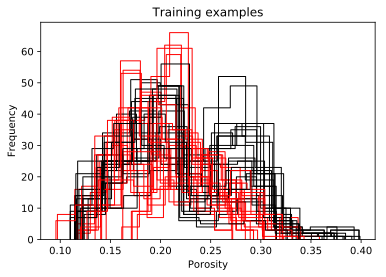

In [39]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output.shape[0],100):
    plt.hist(Y_train[i,0,:], histtype='step', color='black')
    plt.hist(train_output[i,0,:], histtype='step', color='red')
    plt.xlabel('Porosity')
    plt.ylabel('Frequency')
    plt.title('Training examples')


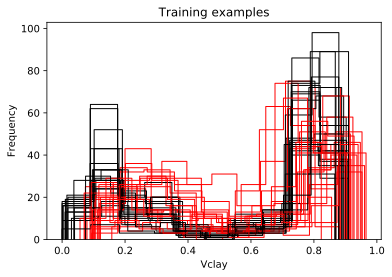

In [41]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output.shape[0],100):
    plt.hist(Y_train[i,1,:], histtype='step', color='black')
    plt.hist(train_output[i,1,:], histtype='step', color='red')
    plt.xlabel('Vclay')
    plt.ylabel('Frequency')
    plt.title('Training examples')

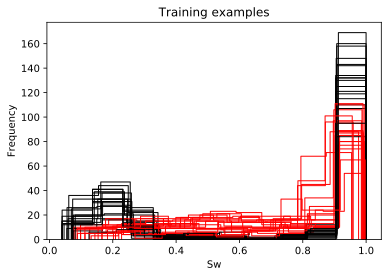

In [42]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output.shape[0],100):
    plt.hist(Y_train[i,2,:], histtype='step', color='black')
    plt.hist(train_output[i,2,:], histtype='step', color='red')
    plt.xlabel('Sw')
    plt.ylabel('Frequency')
    plt.title('Training examples')

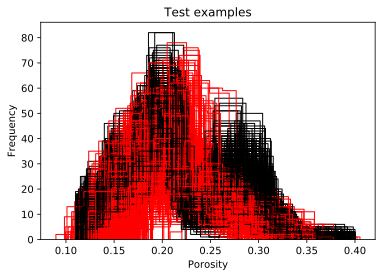

In [43]:
for i in range(test_output.shape[0]):
    plt.hist(Y_test[i,0,:], histtype='step', color='black')
    plt.hist(test_output[i,0,:], histtype='step', color='red')
    plt.xlabel('Porosity')
    plt.ylabel('Frequency')
    plt.title('Test examples')

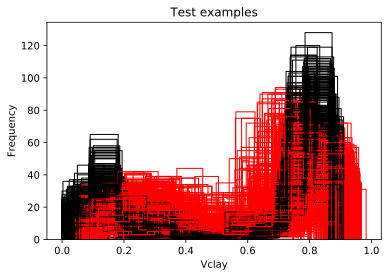

In [44]:
for i in range(test_output.shape[0]):
    plt.hist(Y_test[i,1,:], histtype='step', color='black')
    plt.hist(test_output[i,1,:], histtype='step', color='red')
    plt.xlabel('Vclay')
    plt.ylabel('Frequency')
    plt.title('Test examples')

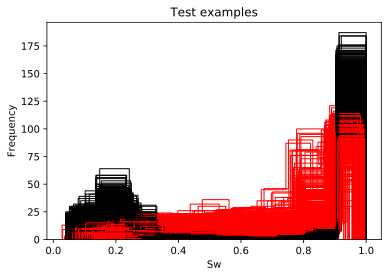

In [45]:
for i in range(test_output.shape[0]):
    plt.hist(Y_test[i,2,:], histtype='step', color='black')
    plt.hist(test_output[i,2,:], histtype='step', color='red')
    plt.xlabel('Sw')
    plt.ylabel('Frequency')
    plt.title('Test examples')

({'var': 0.0025387245328639943,
  'len_scale': 19.937463724251785,
  'nugget': 3.952230954299505e-05},
 array([[ 1.82675235e-08, -7.64057597e-05, -1.69677016e-08],
        [-7.64057597e-05,  1.76041713e+00,  9.89975986e-05],
        [-1.69677016e-08,  9.89975986e-05,  1.73898634e-08]]))

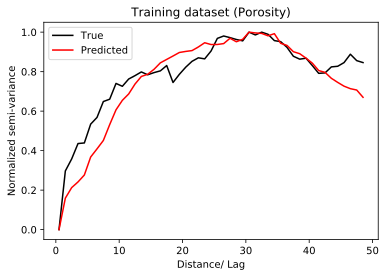

In [24]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 25
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_train[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Training dataset (Porosity)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, train_output[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

({'var': 0.10681063143945146,
  'len_scale': 21.51500769338835,
  'nugget': 7.206276203044684e-20},
 array([[ 3.87808816e-05, -4.00751572e-03, -3.56704426e-05],
        [-4.00751572e-03,  2.48994472e+00,  5.38131304e-03],
        [-3.56704426e-05,  5.38131304e-03,  3.66603210e-05]]))

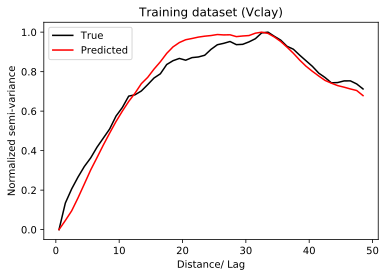

In [25]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 25
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_train[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Training dataset (Vclay)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, train_output[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

({'var': 0.08411661267370808,
  'len_scale': 20.616516306002342,
  'nugget': 0.004213859924972864},
 array([[ 1.16758049e-05, -1.50060642e-03, -1.08001682e-05],
        [-1.50060642e-03,  1.10139968e+00,  1.97282720e-03],
        [-1.08001682e-05,  1.97282720e-03,  1.10809927e-05]]))

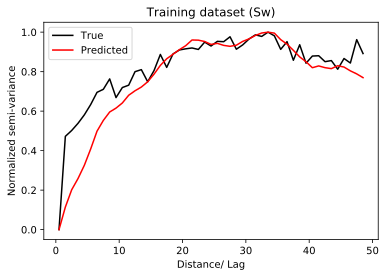

In [26]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 25
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_train[sample_number,2,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Training dataset (Sw)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, train_output[sample_number,2,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

({'var': 0.0018815166677583677,
  'len_scale': 20.64648612274286,
  'nugget': 8.752404047837407e-05},
 array([[ 2.53683205e-08, -1.45874868e-04, -2.34620448e-08],
        [-1.45874868e-04,  4.79936132e+00,  1.91943686e-04],
        [-2.34620448e-08,  1.91943686e-04,  2.40746060e-08]]))

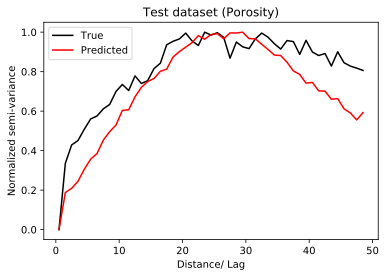

In [27]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 12
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_test[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Test dataset (Porosity)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, test_output[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

({'var': 0.08953290178185785,
  'len_scale': 21.19886375031508,
  'nugget': 7.504607054308629e-23},
 array([[ 6.17615200e-05, -7.56021176e-03, -5.69293359e-05],
        [-7.56021176e-03,  5.47158012e+00,  1.00860365e-02],
        [-5.69293359e-05,  1.00860365e-02,  5.84899549e-05]]))

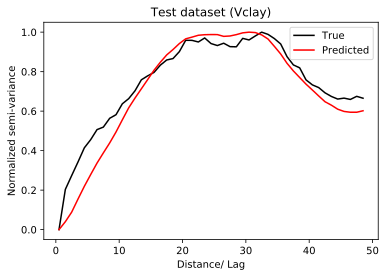

In [28]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 12
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_test[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Test dataset (Vclay)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, test_output[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

({'var': 0.08953290178185785,
  'len_scale': 21.19886375031508,
  'nugget': 7.504607054308629e-23},
 array([[ 6.17615200e-05, -7.56021176e-03, -5.69293359e-05],
        [-7.56021176e-03,  5.47158012e+00,  1.00860365e-02],
        [-5.69293359e-05,  1.00860365e-02,  5.84899549e-05]]))

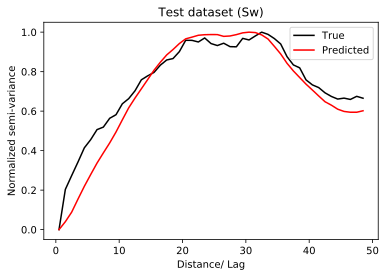

In [29]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 12
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_test[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black")
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Test dataset (Sw)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, test_output[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red")
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

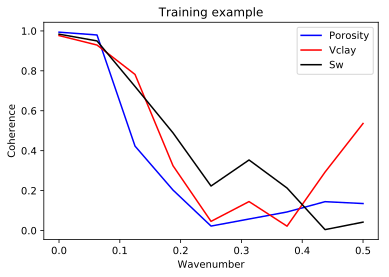

In [31]:
# Spectral coherence between true and predicted 

sample_number = 25
plt.cohere(Y_train[sample_number,0,:], train_output[sample_number,0,:], NFFT=16, Fs=1, color="blue")
plt.cohere(Y_train[sample_number,1,:], train_output[sample_number,1,:], NFFT=16, Fs=1, color="red") 
plt.cohere(Y_train[sample_number,2,:], train_output[sample_number,2,:], NFFT=16, Fs=1, color="black")


plt.gca().legend(('Porosity','Vclay', 'Sw'))
plt.xlabel('Wavenumber')
plt.ylabel('Coherence')
plt.title('Training example')
plt.grid(b=False)

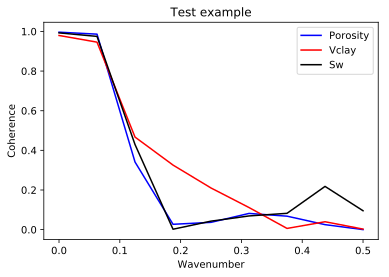

In [32]:
# Spectral coherence between true and predicted 

sample_number = 12
plt.cohere(Y_test[sample_number,0,:], test_output[sample_number,0,:], NFFT=16, Fs=1, color="blue")
plt.cohere(Y_test[sample_number,1,:], test_output[sample_number,1,:], NFFT=16, Fs=1, color="red") 
plt.cohere(Y_test[sample_number,2,:], test_output[sample_number,2,:], NFFT=16, Fs=1, color="black")


plt.gca().legend(('Porosity','Vclay', 'Sw'))
plt.xlabel('Wavenumber')
plt.ylabel('Coherence')
plt.title('Test example')
plt.grid(b=False)